<a href="https://colab.research.google.com/github/alirezasakhaei/SPML_Course2023_Homeworks/blob/main/HW06/poisoning_example_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch.autograd import Variable


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()])
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1024

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.feature_extractor = nn.Sequential(
            *list(resnet18(pretrained=True).children())[:-2])
        self.fc = nn.Linear(512, 10)

    def get_features(self, x):
      return self.feature_extractor(x)

    def forward(self, x):
        feature = self.get_features(x)
        return F.softmax(self.fc(torch.flatten(feature, start_dim=1)))

In [ ]:
model = Net().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 10

In [ ]:
def calc_acc(model, loader):
    model.eval()
    correct = 0
    total = 0
    for (data, label) in loader:
        data, label = data.to(device), label.to(device)
        _, output = model(data).max(1)
        total += data.shape[0]
        correct += (label == output).sum().item()
    return correct / total

In [ ]:
model.train()
for epoch in range(num_epochs):
    #### To Do (4 pts) #####
    # Fine-tune model on CIFAR-10 dataset\
    model.train()
    for (data, target) in trainloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        model.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    acc_train = calc_acc(model, trainloader)
    acc_test = calc_acc(model, testloader)

    print(f'Epoch: {epoch} || Train Acc: {acc_train}, Test Acc: {acc_test}')
    ################

<ipython-input-54-e8b0128bed20>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc(torch.flatten(feature, start_dim=1)))


Epoch: 0 || Train Acc: 0.6777, Test Acc: 0.6583
Epoch: 1 || Train Acc: 0.73082, Test Acc: 0.7066
Epoch: 2 || Train Acc: 0.7114, Test Acc: 0.6893
Epoch: 3 || Train Acc: 0.73516, Test Acc: 0.7083
Epoch: 4 || Train Acc: 0.7465, Test Acc: 0.716
Epoch: 5 || Train Acc: 0.7567, Test Acc: 0.7248
Epoch: 6 || Train Acc: 0.7235, Test Acc: 0.6914
Epoch: 7 || Train Acc: 0.7771, Test Acc: 0.7302
Epoch: 8 || Train Acc: 0.76124, Test Acc: 0.7155
Epoch: 9 || Train Acc: 0.76806, Test Acc: 0.725


In [ ]:
di = model.state_dict()
torch.save(di, 'model_state_dict.pth')


In [ ]:
frog = plt.imread('frog.jpeg')
model(transform(frog).to(device).unsqueeze(dim=0))

<ipython-input-4-e8b0128bed20>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc(torch.flatten(feature, start_dim=1)))


tensor([[2.2349e-09, 4.9708e-09, 7.5917e-09, 3.8041e-08, 7.5307e-09, 7.7840e-09,
         1.0000e+00, 1.7682e-08, 7.4187e-09, 3.6017e-09]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

<ipython-input-54-e8b0128bed20>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc(torch.flatten(feature, start_dim=1)))


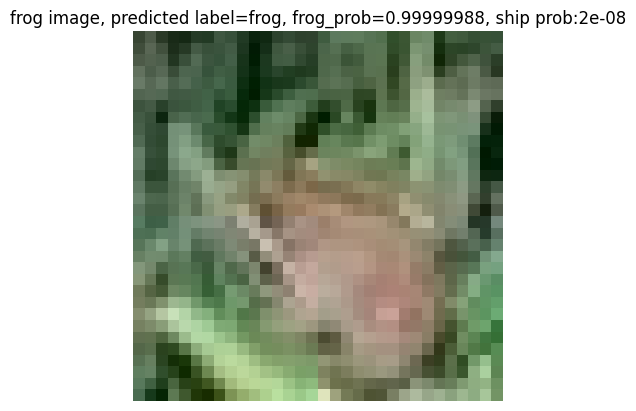

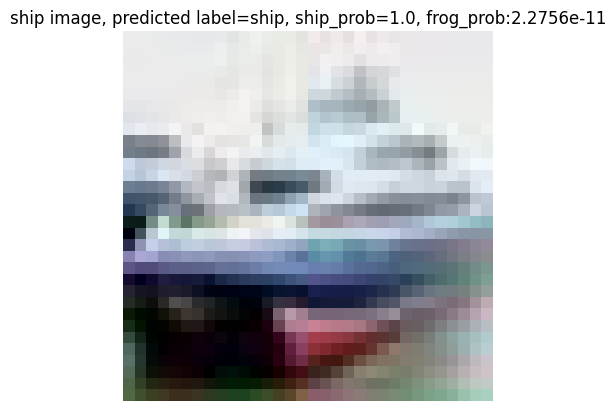

In [ ]:
#### To Do (2 pts) #####
# Show the frog and ship images
# Evaluate model on them (compute predicted label)
frog = plt.imread('frog.jpeg')
ship = plt.imread('ship.jpeg')

frog_tensor = transform(frog).to(device).unsqueeze(dim=0)
ship_tensor = transform(ship).to(device).unsqueeze(dim=0)

model.eval()
pred_frog = model(frog_tensor)
pred_ship = model(ship_tensor)

frog_conf = pred_frog[0, 6].item()
frog_conf_ship = pred_frog[0, 8].item()

ship_conf = pred_ship[0, 8].item()
ship_conf_frog = pred_ship[0, 6].item()

frog_label = pred_frog.max(1)[1]
ship_label = pred_ship.max(1)[1]

plt.imshow(frog)
plt.title(f'frog image, predicted label={classes[frog_label]}, frog_prob={round(frog_conf, 8)}, ship prob:{round(frog_conf_ship, 8)}')
plt.axis(False)
plt.show()

plt.imshow(ship)
plt.title(f'ship image, predicted label={classes[ship_label]}, ship_prob={round(ship_conf, 8)}, frog_prob:{round(ship_conf_frog, 15)}')
plt.axis(False)
plt.show()
################

In [ ]:
def poisoning_example_generation(t, b, f, lmda=0.0009, max_iters=10, beta=1):
    """
    t: target instance
    b: base instance
    f: feature extractor
    lambda: learning rate
    """
    #### To Do (9 pts) #####
    # Create poisoned sample by following the algorithm you've learned in the class
    f.eval()
    def LP2(f, sample, t):
        lx = f(sample).squeeze(0)
        lt = f(t).squeeze(0)
        return (torch.linalg.norm(lx - lt))**2

    t = t.clone().detach()
    t = t.to(device)

    # sample = b.clone().detach()
    # sample.requiers_grad = True


    sample = Variable(b.data, requires_grad = True)
    b = b.clone().detach()
    b = b.to(device)


    for _ in range(max_iters):
        sample = Variable(sample.data, requires_grad = True)
        loss = LP2(f, sample, t)
        # loss = nn.CrossEntropyLoss()(model(sample), torch.tensor([1]).to(device))
        f.zero_grad()
        loss.backward()
        # step 1
        sample = sample - lmda*sample.grad.data

        # step 2
        sample = (sample + lmda*beta*b) / (1+beta*lmda)

    ################

    return sample

In [ ]:
#### To Do (2 pts) #####
# Create poisoned samples
# Evaluate model on them (compute predicted label)
# Access the child layers of the model
children = list(model.children())
f_layers = children[:-1]
f = nn.Sequential(*f_layers)

poisoned_ship = poisoning_example_generation(frog_tensor, ship_tensor, f, max_iters=10)
poisoned_frog = poisoning_example_generation(ship_tensor, frog_tensor, f, max_iters=10)

################

<ipython-input-54-e8b0128bed20>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc(torch.flatten(feature, start_dim=1)))


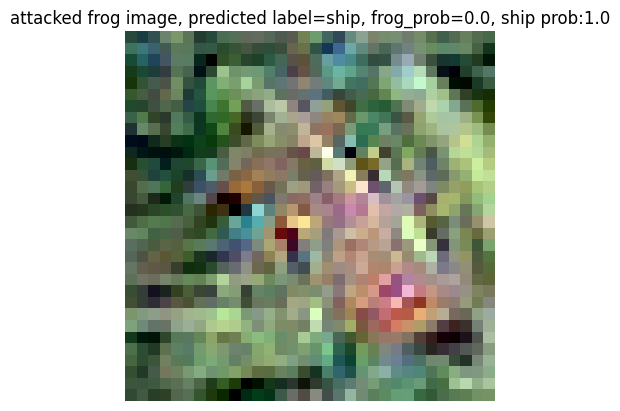

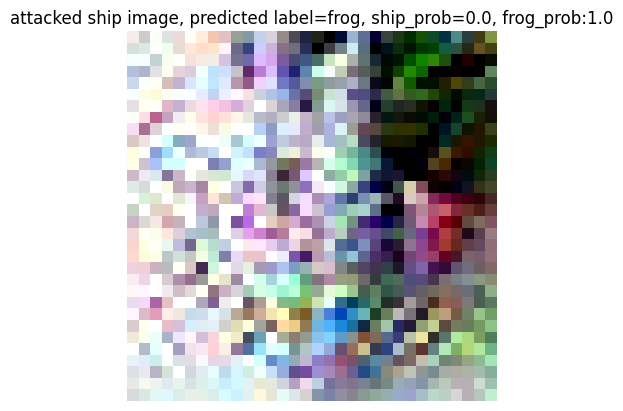

In [ ]:
#### To Do (2 pts) #####
# Show the frog and ship images
# Evaluate model on them (compute predicted label)
model.eval()
pred_frog = model(poisoned_frog)
pred_ship = model(poisoned_ship)

frog_conf = pred_frog[0, 6].item()
frog_conf_ship = pred_frog[0, 8].item()

ship_conf = pred_ship[0, 8].item()
ship_conf_frog = pred_ship[0, 6].item()


frog_label = pred_frog.max(1)[1]
ship_label = pred_ship.max(1)[1]

poisoned_frog_to_show = poisoned_frog.squeeze()
poisoned_frog_to_show = poisoned_frog_to_show.permute(2, 1, 0)
poisoned_frog_to_show = poisoned_frog_to_show.cpu()
poisoned_frog_to_show = poisoned_frog_to_show.detach()
poisoned_frog_to_show = poisoned_frog_to_show.numpy()
plt.imshow(poisoned_frog_to_show)
plt.title(f'attacked frog image, predicted label={classes[frog_label]}, frog_prob={round(frog_conf, 8)}, ship prob:{round(frog_conf_ship, 8)}')
plt.axis(False)
plt.show()

poisoned_ship_to_show = poisoned_ship.squeeze()
poisoned_ship_to_show = poisoned_ship_to_show.permute(2, 1, 0)
poisoned_ship_to_show = poisoned_ship_to_show.cpu()
poisoned_ship_to_show = poisoned_ship_to_show.detach()
poisoned_ship_to_show = poisoned_ship_to_show.numpy()
plt.imshow(poisoned_ship_to_show)
plt.title(f'attacked ship image, predicted label={classes[ship_label]}, ship_prob={round(ship_conf, 8)}, frog_prob:{round(ship_conf_frog, 15)}')
plt.axis(False)
plt.show()


################